## Define file path

In [1]:
fpath = '/Users/yungkuo/Google Drive/HFSP internal sharing space/Data/Anastasia/biphasic train recordings/' # path of folder
fname = 'cell1_biphasic train1' # file name of fluorescence movie without .tif
bfname = 'cell1_bf' # file name of bright-field image without .tif
ivname = 'cell1_biphasic train1' # file name of iv curve without .abf

In [2]:
framerate = 1000 #Hz, camera framerate

## Import functions

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tff
from neo import io
import ROI
import scipy.ndimage as ndi
import matplotlib
import pandas as pd
from IPython.display import display

In [4]:
#from sys import platform
#if platform == 'darwin':
#    %config InlineBackend.figure_format = 'retina'

## Import movie and bright-field image then plot

In [5]:
tiffimg = tff.TiffFile(fpath+fname+'.tif')
movie = tiffimg.asarray()
movie = movie[:,:,:]
print('movie size = {}'.format(movie.shape))

movie size = (9999, 32, 512)


### Exam intensity as function of time 

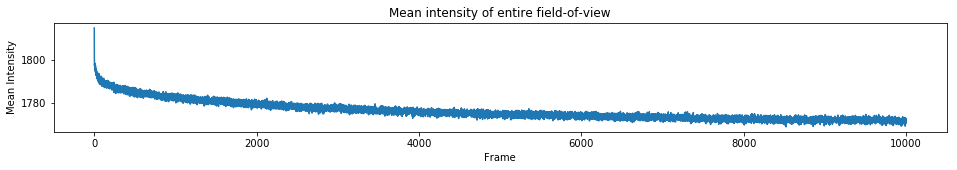

In [6]:
plt.figure(figsize=(16,2))
plt.plot(movie.mean(1).mean(1))
plt.title('Mean intensity of entire field-of-view')
plt.ylabel('Mean Intensity')
plt.xlabel('Frame')

### Plot bright-field image

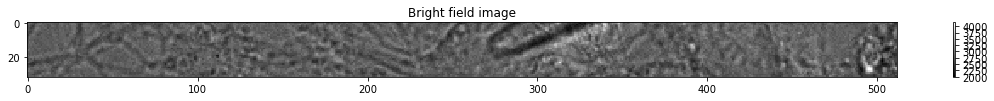

In [7]:
tiffimg = tff.TiffFile(fpath+bfname+'.tif')
bf = tiffimg.asarray()
plt.figure(figsize=(20,1))
plt.imshow(bf, cmap='gray')
plt.colorbar()
plt.title('Bright field image')

### Plot mean fluorescence image

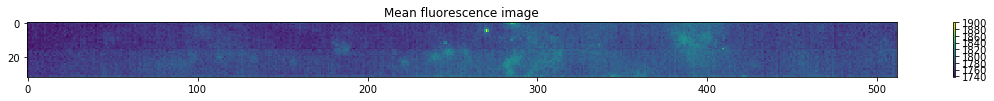

In [8]:
plt.figure(figsize=(20,1))
plt.imshow(movie.mean(0), cmap='viridis', vmax=1900, interpolation='none')
plt.colorbar()
plt.title('Mean fluorescence image')

## Import IV curves then plot

In [364]:
r = io.AxonIO(fpath+ivname+'.abf')
bl = r.read_block(lazy=False, cascade=True)

/Users/yungkuo/anaconda/lib/python3.5/site-packages/neo/io/axonio.py:261: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  nbchannel)).astype('f')


In [374]:
bl

Block with 1 segments
annotations: {'abf_version': 2.6000000000000001}
file_origin: 'cell1_biphasic train1.abf'
rec_datetime: datetime.datetime(2017, 3, 16, 19, 2, 4, 649000)
# segments (N=1)
0: Segment with 2 analogsignals, 1 eventarrays
   # analogsignals (N=2)
   0: AnalogSignal in 1.0 pA with 130000 float32 values
      name: "b'Vm_primary'"
      channel index: 0
      sampling rate: 10000.0 Hz
      time: 0.0 s to 13.0 s
   1: AnalogSignal in 1.0 mV with 130000 float32 values
      name: "b'Im_sec'"
      channel index: 1
      sampling rate: 10000.0 Hz
      time: 0.0 s to 13.0 s
   # analogsignalarrays (N=0)

(0, 0.5)

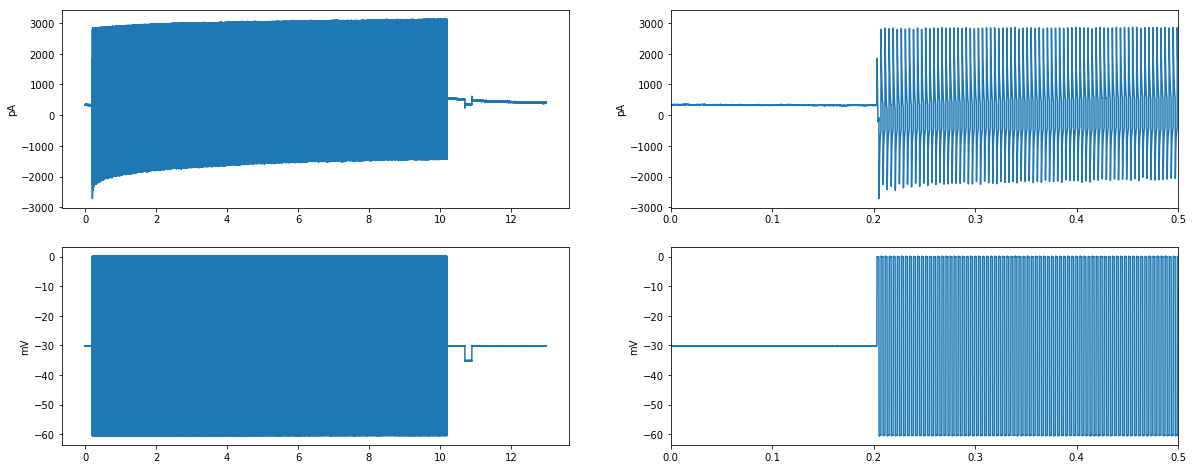

In [383]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
for i, seg in enumerate(bl.segments):
    for j in range(2):
        ax[0,j].plot(np.arange(len(seg.analogsignals[0]))/10000, seg.analogsignals[0])
        ax[1,j].plot(np.arange(len(seg.analogsignals[0]))/10000, seg.analogsignals[1])
        ax[0,j].set_ylabel('pA')
        ax[1,j].set_ylabel('mV')
ax[0,j].set_xlim(0,0.5)
ax[1,j].set_xlim(0,0.5)

## Find particles

In [12]:
def get_acr(movie, pt, pad):
    tt = ROI.get_timetrace(movie, pt, pad)
    tt = tt - np.mean(tt[:])
    acr = np.correlate(tt, tt, mode='full')
    acr = acr[len(acr)//2:]
    return acr

In [13]:
acr_img = np.zeros((movie.shape[1], movie.shape[2]))
for i in range(movie.shape[1]):
    for j in range(movie.shape[2]):
        acr_img[i,j] = np.mean(get_acr(movie, [j,i], [0,0]))

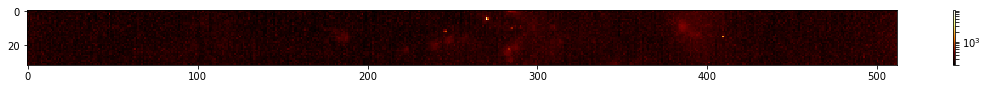

In [23]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(20,1))
plt.imshow(acr_img, cmap='afmhot', interpolation='none', norm=LogNorm())
plt.colorbar()

#### Automatic detection of particles

In [86]:
scan = [1,1]
pts = ROI.finddot(acr_img, scan, nstd=1.2)

In [87]:
pts, len(pts)

(array([[ 270.,    5.],
        [ 385.,    9.],
        [ 285.,   10.],
        [ 310.,   10.],
        [ 246.,   12.],
        [ 394.,   14.],
        [ 187.,   16.],
        [ 176.,   18.],
        [ 248.,   18.],
        [ 313.,   18.],
        [ 240.,   19.],
        [ 223.,   22.],
        [ 283.,   22.]]), 13)

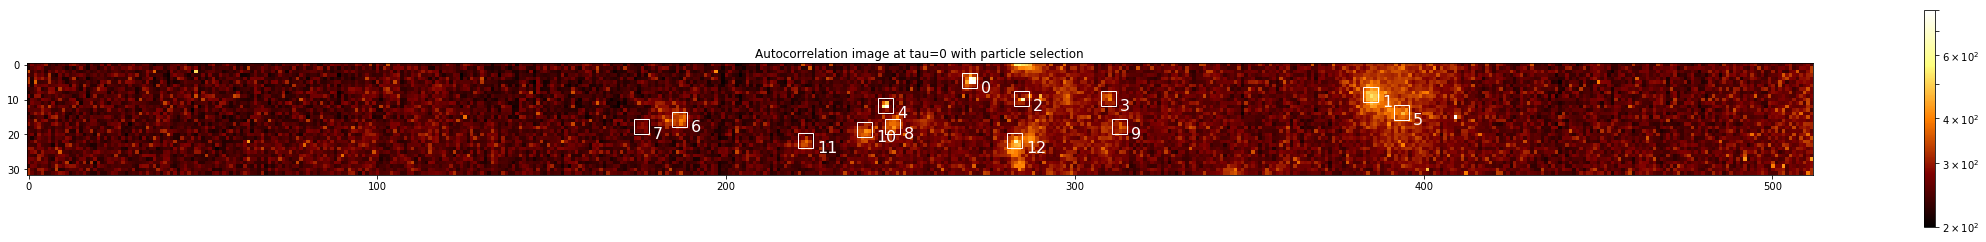

In [88]:
fig, ax = plt.subplots(figsize=(40,4))
ax.plot(pts[:,0]-0.5, pts[:,1]-0.5, 'ws', fillstyle='none', ms=15)
im = ax.imshow(acr_img, cmap='afmhot', interpolation='none', norm=LogNorm(vmax=800))
for count, pt in enumerate(pts):
    ax.annotate(count, xy=pt+[3,3], color='w', fontsize=16)
plt.colorbar(im)
plt.title('Autocorrelation image at tau=0 with particle selection')

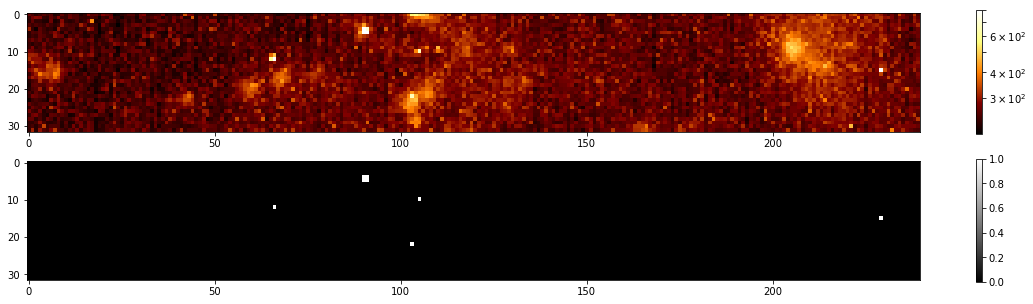

In [300]:
min100 = np.sort(acr_img.flatten())[:1000]
mask = acr_img > np.mean(min100)*3
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.imshow(acr_img[:,180:420], norm=LogNorm(vmax=800), cmap='afmhot')
plt.colorbar()
plt.subplot(212)
plt.imshow(mask[:,180:420], cmap='gray')
plt.colorbar()

In [301]:
pts_mask = ROI.finddot(mask, [1,1], nstd=0)

In [302]:
pts_mask

array([[ 270.,    4.],
       [ 271.,    4.],
       [ 270.,    5.],
       [ 271.,    5.],
       [ 285.,   10.],
       [ 246.,   12.],
       [ 409.,   15.],
       [ 283.,   22.]])

In [307]:
pts_mask = np.array([[ 271.,    5.],
       [ 285.,   10.],
       [ 246.,   12.],
       [ 409.,   15.],
       [ 283.,   22.]])

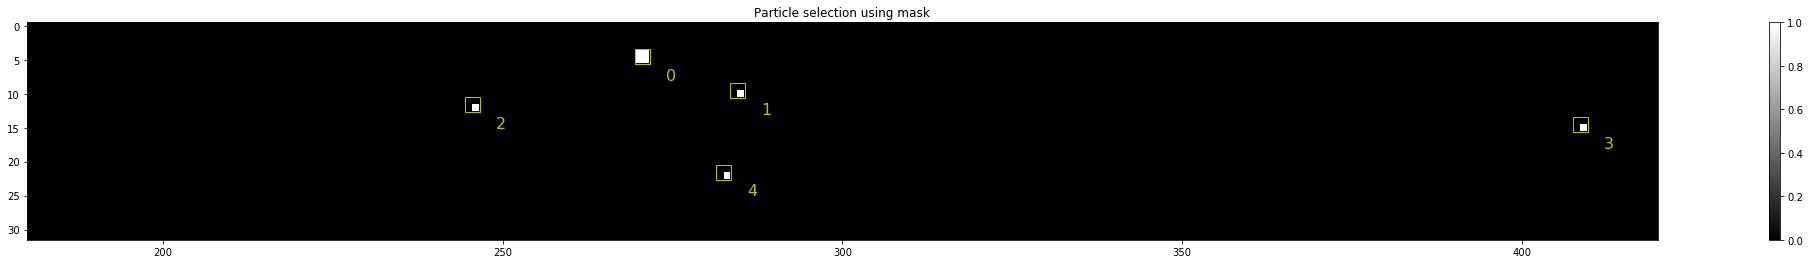

In [308]:
fig, ax = plt.subplots(figsize=(40,4))
ax.plot(pts_mask[:,0]-0.5, pts_mask[:,1]-0.5, 'ys', fillstyle='none', ms=15)
im = ax.imshow(mask, cmap='gray', interpolation='none')
for count, pt in enumerate(pts_mask):
    ax.annotate(count, xy=pt+[3,3], color='y', fontsize=16)
ax.set_xlim(180, 420)
plt.colorbar(im)
plt.title('Particle selection using mask')

### Select square ROI

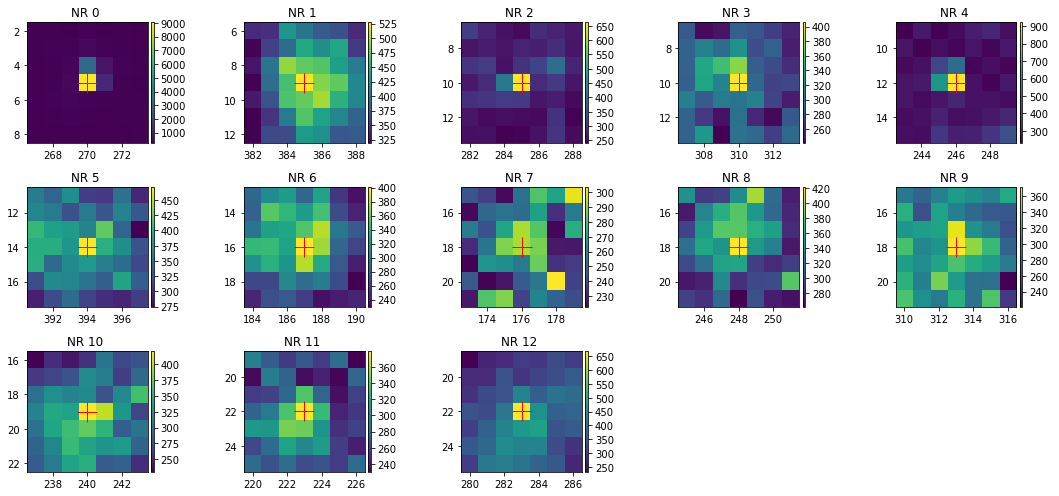

In [309]:
fig, ax = ROI.plot_roi(acr_img, pts, [3,3], ncol=5)#, cmap='afmhot')
display(fig)

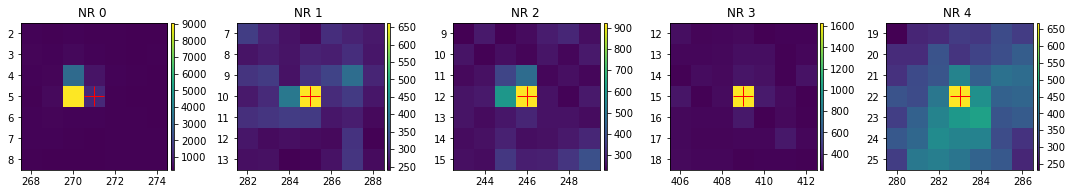

In [310]:
fig, ax = ROI.plot_roi(acr_img, pts_mask, [3,3], ncol=5)#, cmap='afmhot')
display(fig)

### High pass filter

In [103]:
sigma = 10
movie_LPed = np.zeros(movie.shape)
for i in range(movie.shape[0]):
    movie_LPed[i,:,:] = ndi.gaussian_filter(movie[i,:,:], sigma)
movie_HPed = movie - movie_LPed

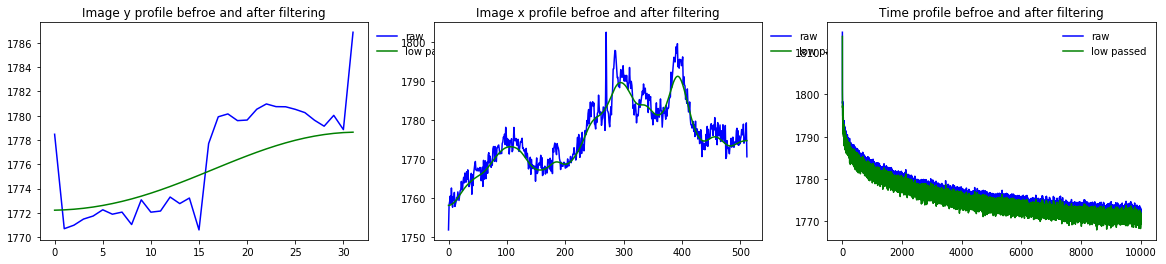

In [115]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
ax[0].plot(movie.mean(0).mean(1), 'b', label='raw')
ax[0].plot(movie_LPed.mean(0).mean(1), 'g', label='low passed')
#ax[0].plot(movie_HPed.mean(0).mean(1), 'r', label='high passed')
ax[0].set_title('Image y profile befroe and after filtering')
ax[0].legend(frameon=False, bbox_to_anchor=(1,1))

ax[1].plot(movie.mean(0).mean(0), 'b', label='raw')
ax[1].plot(movie_LPed.mean(0).mean(0), 'g', label='low passed')
#ax[1].plot(movie_HPed.mean(0).mean(0), 'r', label='high passed')
ax[1].set_title('Image x profile befroe and after filtering')
ax[1].legend(frameon=False, bbox_to_anchor=(1,1))

ax[2].plot(movie.mean(1).mean(1), 'b', label='raw')
ax[2].plot(movie_LPed.mean(1).mean(1), 'g', label='low passed')
#ax[2].plot(movie_HPed.mean(1).mean(1), 'r', label='high passed')
ax[2].set_title('Time profile befroe and after filtering')
ax[2].legend(frameon=False, bbox_to_anchor=(1,1))

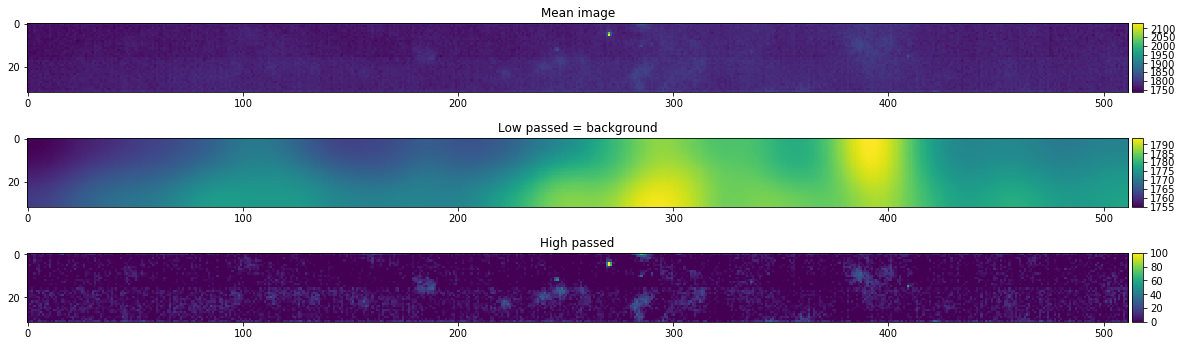

In [105]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
L = np.mean(movie_LPed, axis=0)
H = np.mean(movie_HPed, axis=0)
im = {}
fig, ax = plt.subplots(3,1, figsize=(20,6))
im['0'] = ax[0].imshow(movie.mean(0), cmap='viridis')
im['1'] = ax[1].imshow(L, cmap='viridis')
im['2'] = ax[2].imshow(H, cmap='viridis', vmin=0, vmax=100)
ax[0].set_title('Mean image')
ax[1].set_title('Low passed = background')
ax[2].set_title('High passed')

for i in range(3):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    fig.colorbar(im[str(i)], cax=cax)
plt.subplots_adjust(wspace = 0.5) 

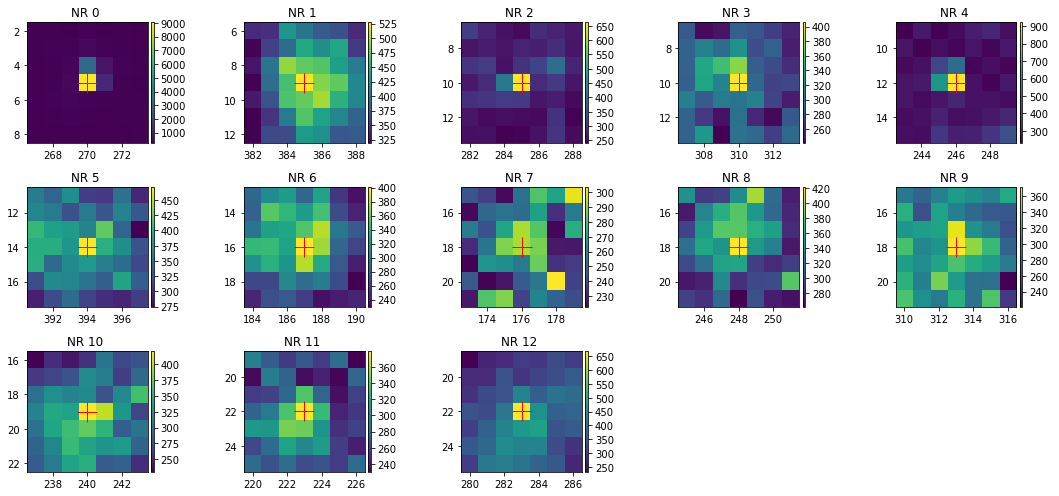

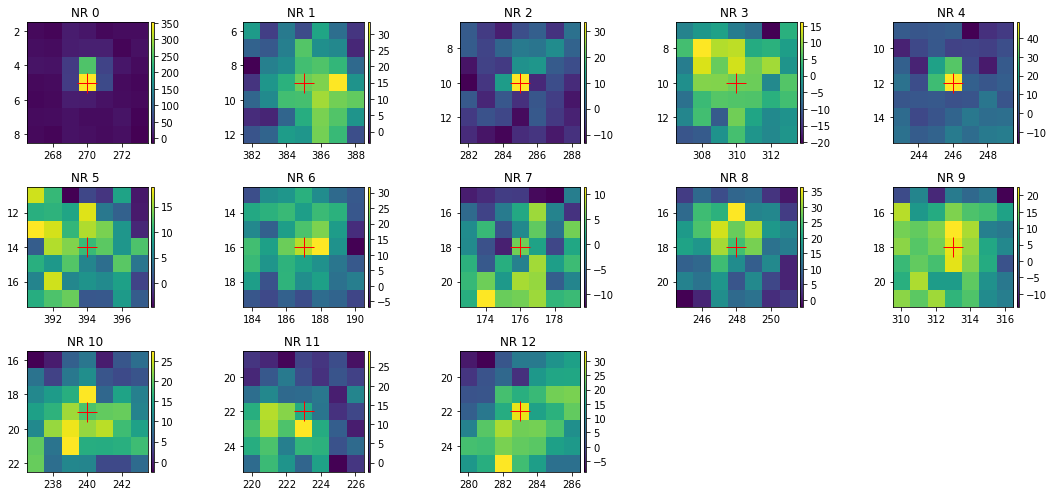

In [148]:
fig, ax = ROI.plot_roi(acr_img, pts, [3,3], ncol=5)#, cmap='afmhot')
display(fig)
fig, ax = ROI.plot_roi(movie_HPed.mean(0), pts, [3,3], ncol=5)
display(fig)

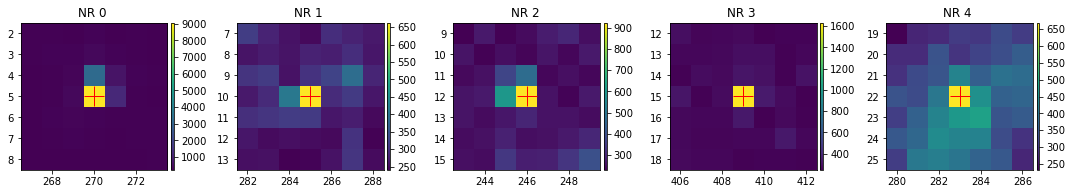

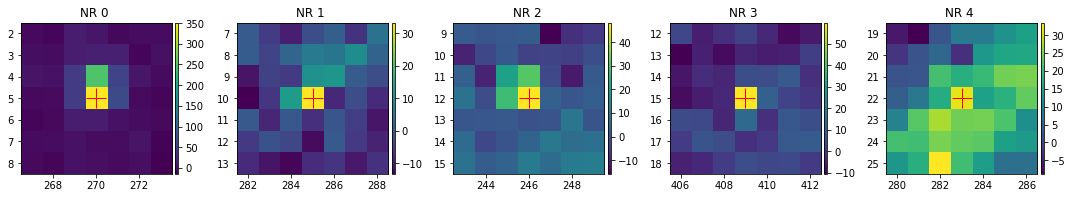

In [251]:
fig, ax = ROI.plot_roi(acr_img, pts_mask, [3,3], ncol=5)#, cmap='afmhot')
display(fig)
fig, ax = ROI.plot_roi(movie_HPed.mean(0), pts_mask, [3,3], ncol=5)
display(fig)

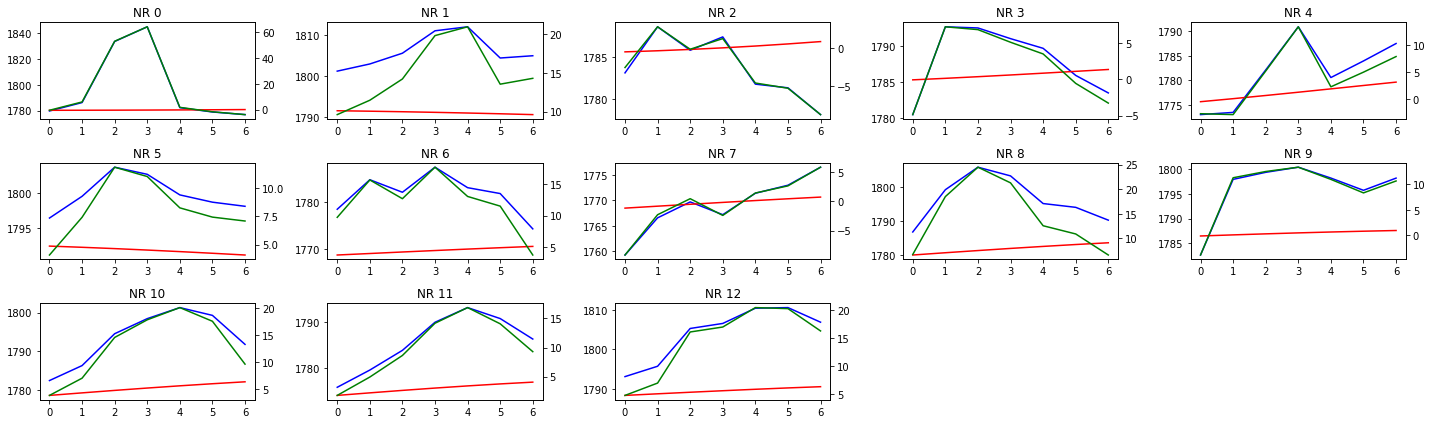

In [107]:
fig, ax = plt.subplots(len(pts)//5+1, 5, figsize=(20,len(pts)//5*3))
ax = ax.ravel()
for count, pt in enumerate(pts):
    roi = ROI.get_roi_square_3d(pt, [3,3])
    if roi[1].start < 0:
        roi = (slice(None), slice(0, roi[1].stop), slice(roi[2].start, roi[2].stop))
    if roi[2].start < 0:
        roi = (slice(None), slice(roi[1].start, roi[1].stop), slice(0, roi[2].stop))
    raw = movie[roi].mean(0).mean(1)
    L = movie_LPed[roi].mean(0).mean(1)
    H = movie_HPed[roi].mean(0).mean(1)
    ax[count].plot(raw, 'b')
    ax[count].plot(L, 'r')
    axt = ax[count].twinx()
    axt.plot(H, 'g')
    ax[count].set_title('NR %d' % count)
for a in ax[count+1:]:
    a.patch.set_visible(False)
    a.axis('off')
fig.tight_layout()
plt.close(fig)
display(fig)

## Different background subtraction methods

#### Plot time trace in each ROI

In [261]:
scan = [1,1]
T = np.arange(movie.shape[0])/framerate
bg_choice = 2
# 0=choose highest 6 pixels as signal, lowest 3 pixels as background; 
# 1=Gaussian low-pass filter;
# 2=choose pixels above median as signal, below as background

#### Extract time trace from pts

In [317]:
TT = pd.DataFrame()
for count, pt in enumerate(pts):
    roi = ROI.get_roi_square_3d(pt, scan)
    if bg_choice == 0:
        roisort = np.sort(np.reshape(movie[roi], (movie.shape[0], (scan[0]*2+1)*(scan[1]*2+1))), axis=1)
        bg = np.mean(roisort[:,:3], axis=1)
        tt = np.mean(roisort[:,3:], axis=1)
    elif bg_choice == 1:
        tt = movie[roi].mean(1).mean(1)
        bg = movie_LPed[roi].mean(1).mean(1)
    elif bg_choice == 2:
        roisort = np.sort(np.reshape(movie[roi], (movie.shape[0], (scan[0]*2+1)*(scan[1]*2+1))), axis=1)
        bg = np.mean(roisort[:,:roisort.shape[1]//2], axis=1)
        tt = np.mean(roisort[:,roisort.shape[1]//2:], axis=1)
    TT1 = pd.DataFrame({'%dtt'% count:tt, '%dbg' % count:bg}, index=np.arange(movie.shape[0]))
    TT = pd.concat([TT,TT1], axis=1)

#### Extract time trace from pts_mask

In [318]:
for count, pt in enumerate(pts_mask):
    roi = ROI.get_roi_square_3d(pt, scan)
    if bg_choice == 0:
        roisort = np.sort(np.reshape(movie[roi], (movie.shape[0], (scan[0]*2+1)*(scan[1]*2+1))), axis=1)
        bg = np.mean(roisort[:,:3], axis=1)
        tt = np.mean(roisort[:,3:], axis=1)
    elif bg_choice == 1:
        tt = movie[roi].mean(1).mean(1)
        bg = movie_LPed[roi].mean(1).mean(1)
    elif bg_choice == 2:
        roisort = np.sort(np.reshape(movie[roi], (movie.shape[0], (scan[0]*2+1)*(scan[1]*2+1))), axis=1)
        bg = np.mean(roisort[:,:roisort.shape[1]//2], axis=1)
        tt = np.mean(roisort[:,roisort.shape[1]//2:], axis=1)
    TT1 = pd.DataFrame({'%dmtt'% count:tt, '%dmbg' % count:bg}, index=np.arange(movie.shape[0]))
    TT = pd.concat([TT,TT1], axis=1)

In [319]:
TT[:5]

0bg     0tt      1bg     1tt      2bg     2tt      3bg     3tt  \
0  1828.50  2072.0  1889.25  1943.2  1813.25  1859.8  1832.50  1863.8   
1  1853.50  2060.2  1896.75  1925.6  1805.25  1851.2  1831.75  1858.0   
2  1872.50  2054.4  1894.50  1934.4  1792.00  1830.4  1810.25  1867.8   
3  1850.75  2040.0  1883.00  1919.0  1793.00  1819.8  1795.75  1839.0   
4  1855.75  2074.8  1865.75  1903.2  1799.25  1842.4  1827.50  1863.6   

       4bg     4tt   ...       0mbg    0mtt     1mbg    1mtt     2mbg    2mtt  \
0  1825.75  1921.8   ...    1798.75  2063.0  1813.25  1859.8  1825.75  1921.8   
1  1806.00  1868.8   ...    1818.75  2056.8  1805.25  1851.2  1806.00  1868.8   
2  1801.50  1864.8   ...    1824.25  2045.6  1792.00  1830.4  1801.50  1864.8   
3  1791.00  1855.8   ...    1800.50  2026.8  1793.00  1819.8  1791.00  1855.8   
4  1803.25  1899.6   ...    1832.75  2065.8  1799.25  1842.4  1803.25  1899.6   

      3mbg    3mtt     4mbg    4mtt  
0  1812.00  1928.2  1880.25  1909.6  
1  1832.25  1908.2  1865.75  1906.0  
2  1802.00  1862.4  1841.25  1921.4  
3  1825.25  1864.8  1849.75  1896.4  
4  1802.75  1868.4  1845.25  1873.2  

[5 rows x 36 columns]

In [295]:
TT.shape

(9999, 36)

In [421]:
TT.to_csv(fpath+fname+'_tt(bg%d).csv' % (bg_choice))

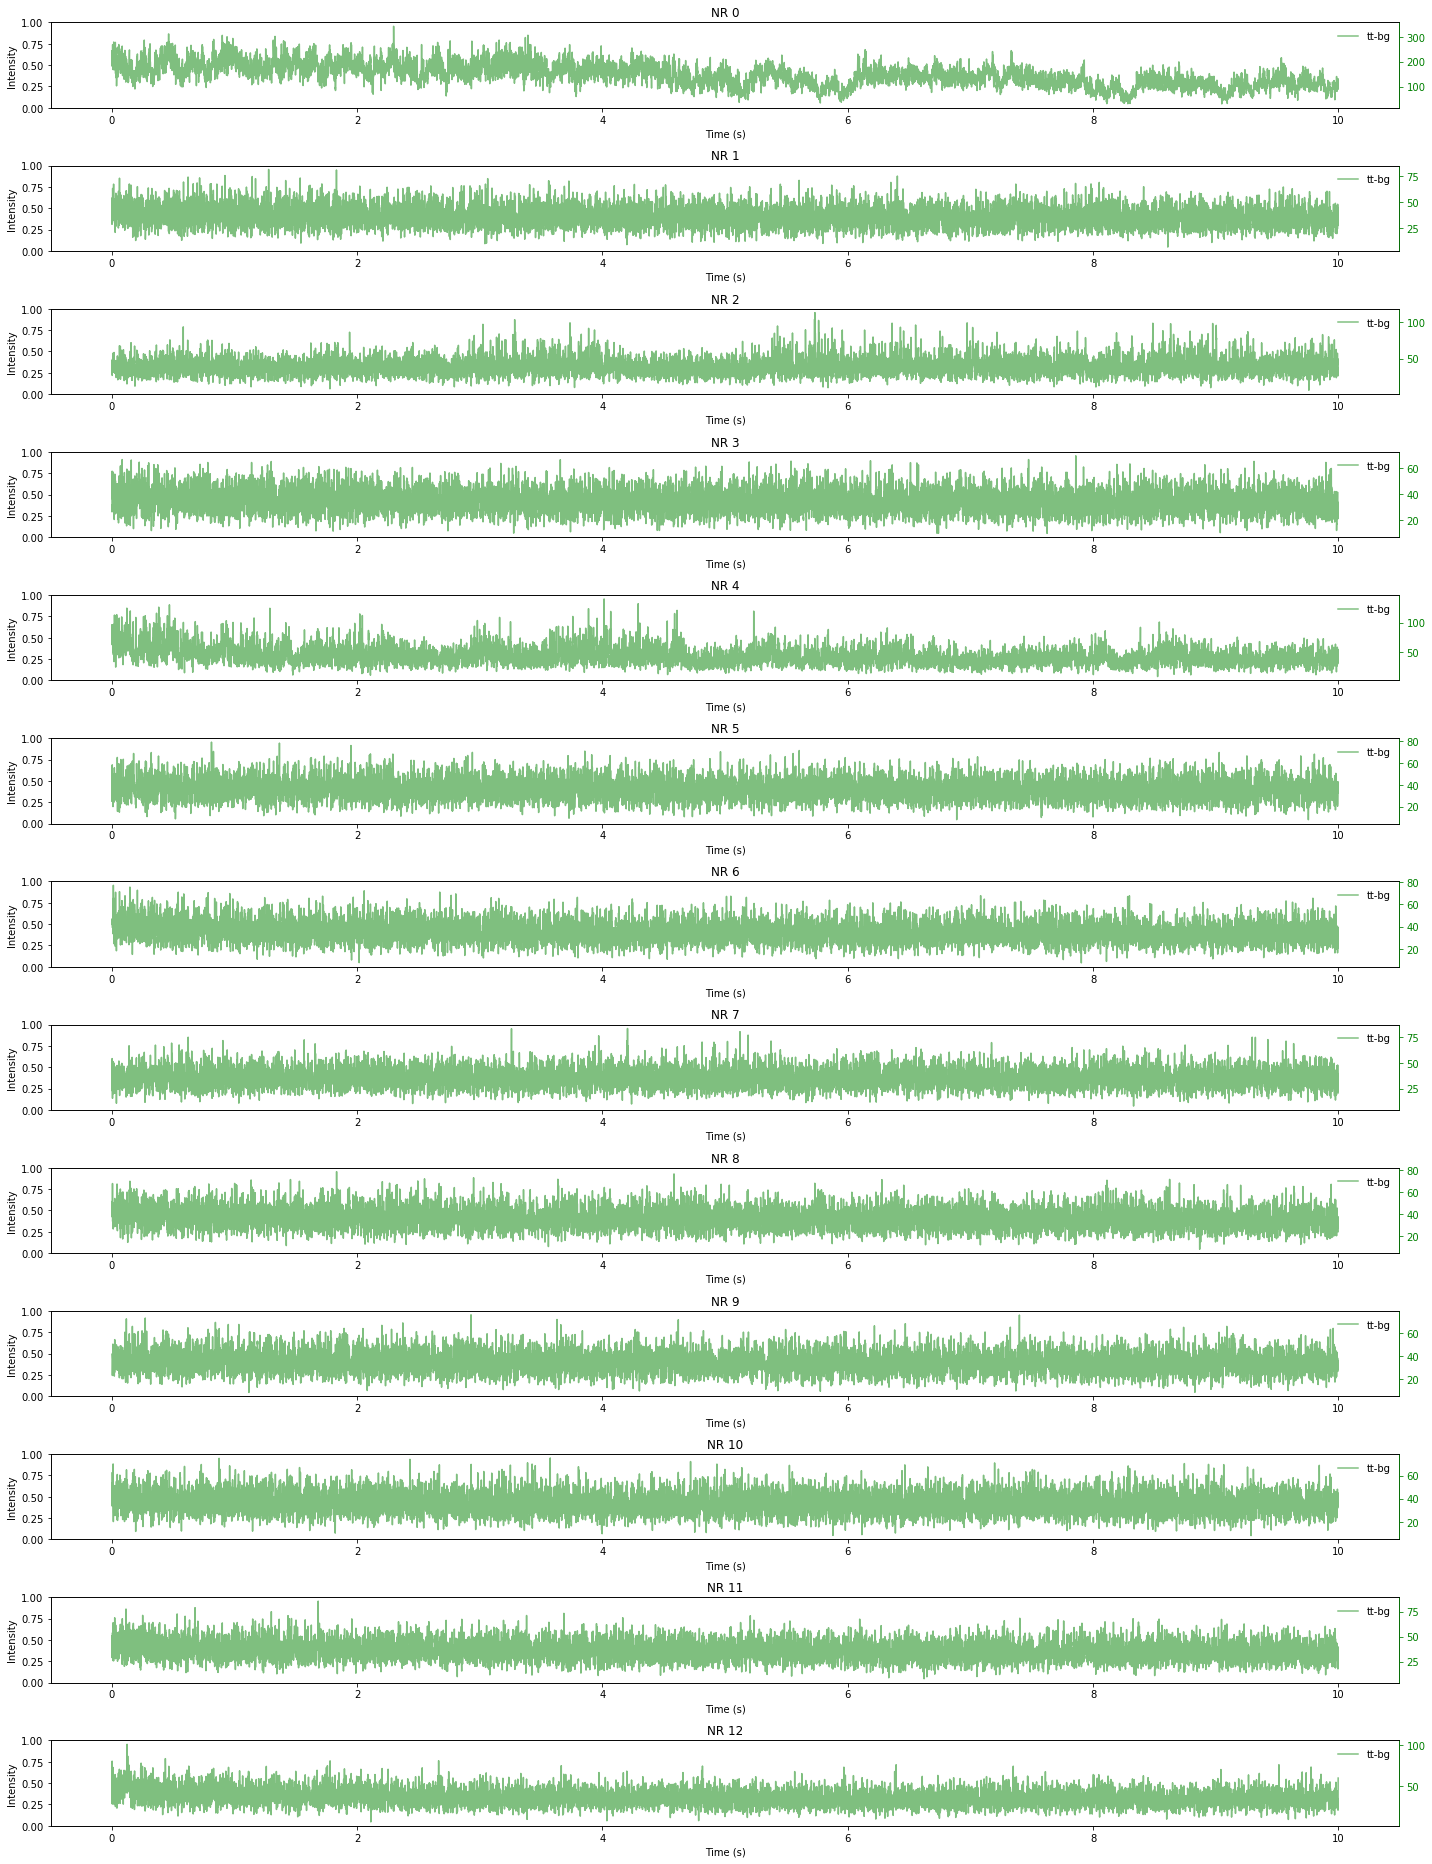

In [473]:
plot_raw = False
plot_bg = False
plot_bgsubtract = True

fig, ax = plt.subplots(len(pts), figsize=(20,len(pts)*2))
for count in range(len(pts)):
    tt = TT[str(count)+'tt']
    bg = TT[str(count)+'bg']
    if plot_raw:
        ax[count].plot(T, tt, 'b', label='tt, highest 6 pixels', alpha=0.5)
        ax[count].legend(frameon=False)
    if plot_bg:
        ax[count].plot(T, bg, 'r', label='bg, lowest 3 pixels', alpha=0.5)
        ax[count].legend(frameon=False)
    if plot_bgsubtract:
        axt = ax[count].twinx()
        axt.plot(T, tt-bg, 'g', label='tt-bg', alpha=0.5)
        axt.legend(frameon=False)
        axt.spines['right'].set_color('g')
        axt.yaxis.label.set_color('g')
        axt.tick_params(axis='y', colors='g')

    ax[count].set_title('NR %d' % count)
    ax[count].set_ylabel('Intensity')
    ax[count].set_xlabel('Time (s)')

fig.tight_layout()
plt.close(fig)
display(fig)

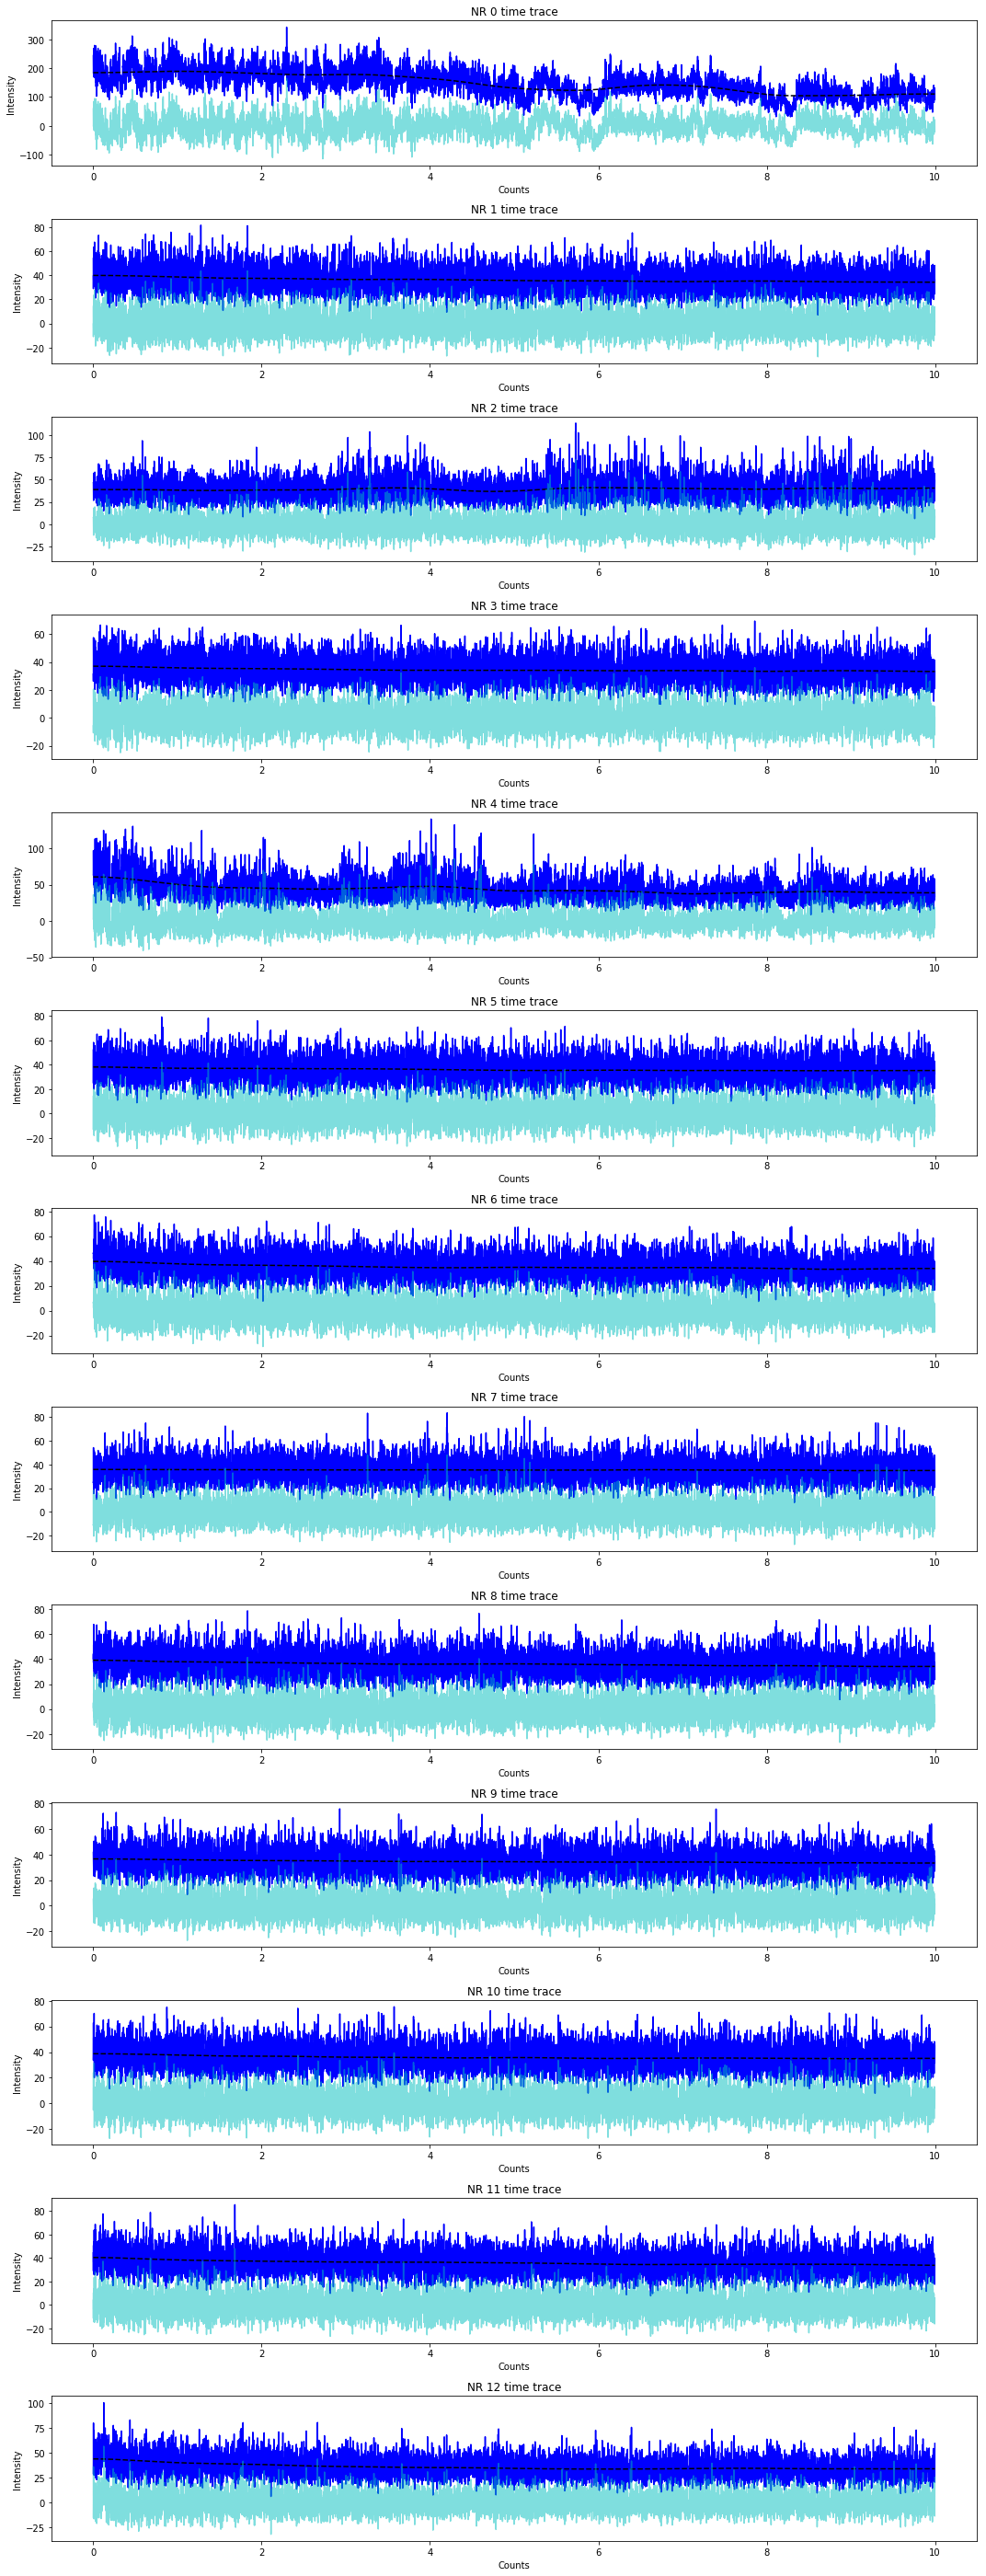

In [516]:
detrend_sigma = 400
fig, ax = plt.subplots(len(pts), figsize=(15,len(pts)*3))
for count in range(len(pts)):
    tt = TT[str(count)+'tt']
    bg = TT[str(count)+'bg']
    
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    
    ax[count].plot(T, tt-bg, 'b', label='tt-bg')
    ax[count].plot(T, trend, 'k', ls='--', label='Gaussian filter (sigma=%d)' % detrend_sigma)
    ax[count].plot(T, ttf, 'c', alpha=0.5, label='filtered')
    
    ax[count].set_title('NR %d time trace' % count)
    ax[count].set_ylabel('Intensity')
    ax[count].set_xlabel('Counts')
fig.tight_layout()
plt.close(fig)
display(fig)

In [482]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [517]:
window_size = 100

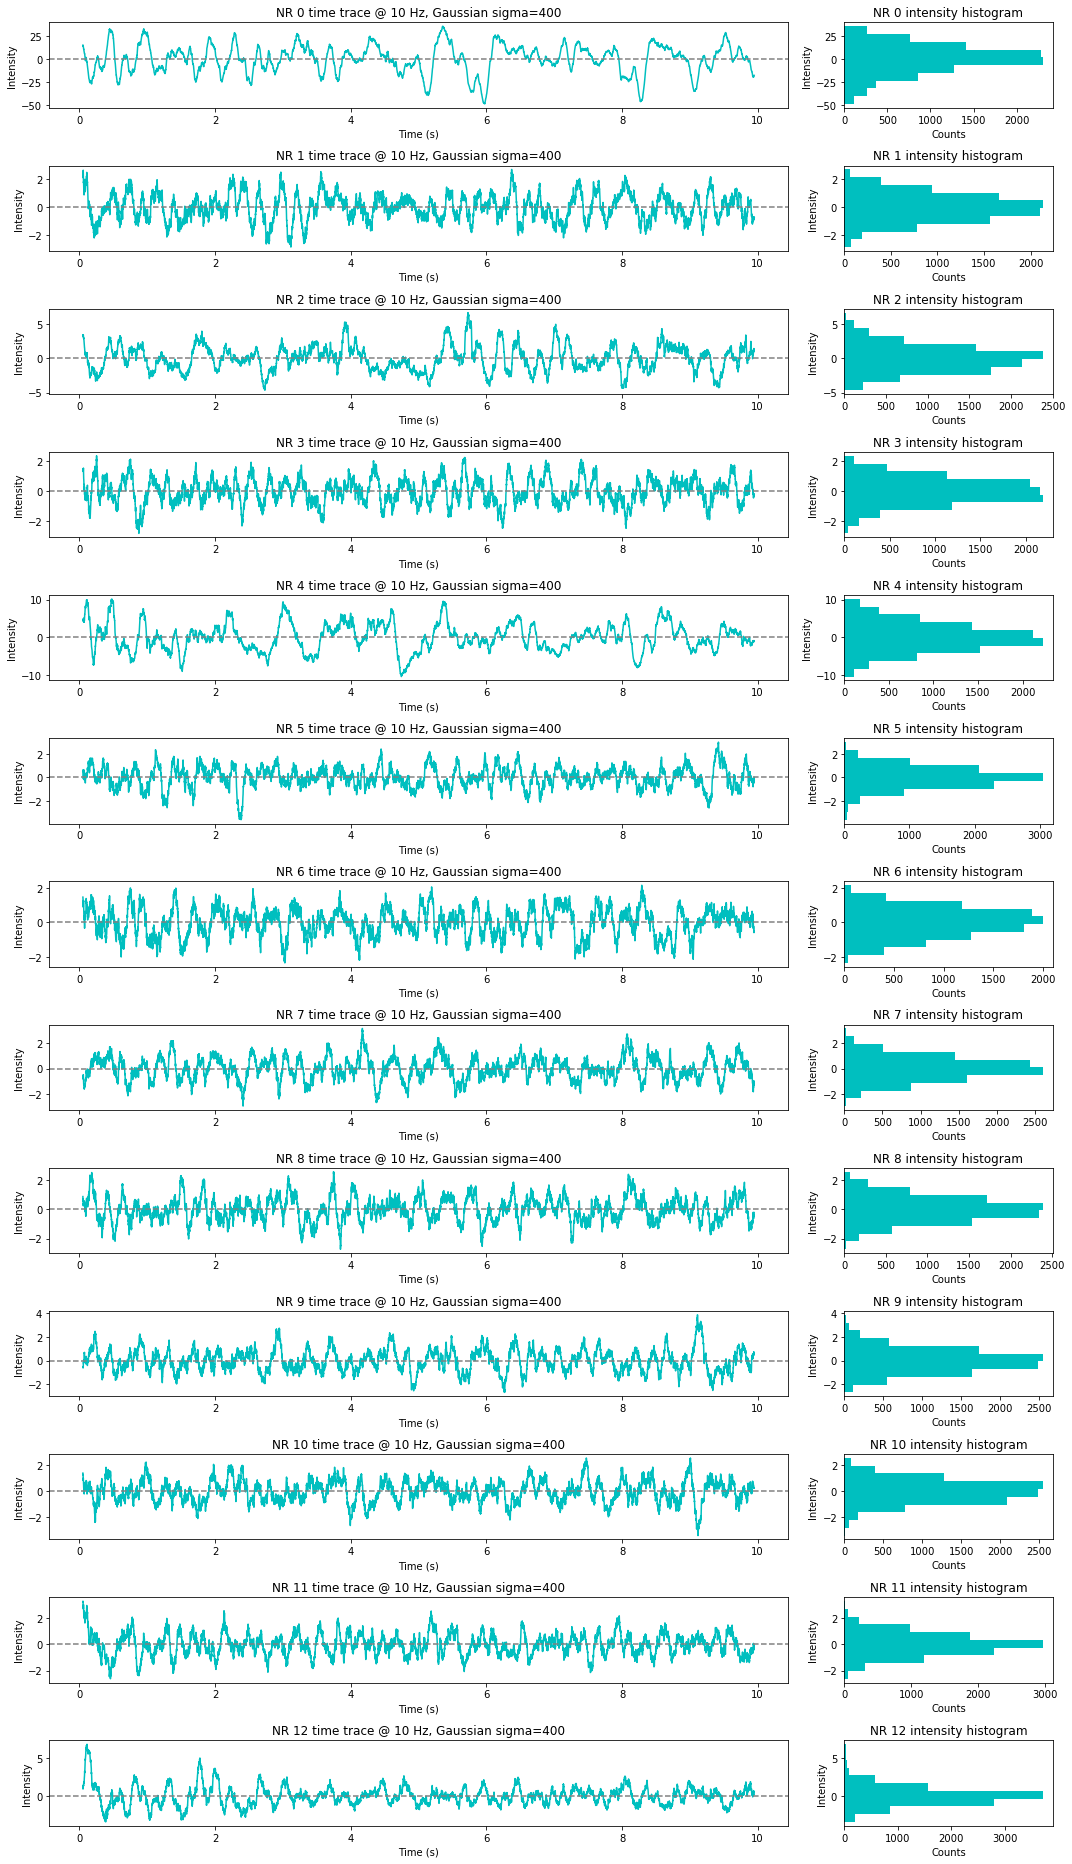

In [518]:
fig, ax = plt.subplots(len(pts),4, figsize=(15,len(pts)*2))
for count in range(len(pts)):
    tt = TT[str(count)+'tt']
    bg = TT[str(count)+'bg']
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    ttbin = movingaverage(ttf, window_size)
    ax[count,0] = plt.subplot2grid((len(pts),4), (count,0), colspan=3, rowspan=1)
    ax[count,1] = plt.subplot2grid((len(pts),4), (count,3), colspan=1, rowspan=1)

    ax[count,0].plot(T[window_size//2:-window_size//2], 
                     ttbin[window_size//2:-window_size//2], 'c')
    ax[count,0].set_title('NR %d time trace @ %d Hz, Gaussian sigma=%d' % (count,1/window_size*1000, detrend_sigma))
    ax[count,0].set_ylabel('Intensity')
    ax[count,0].set_xlabel('Time (s)')
    ax[count,0].axhline(y=0, ls='--', color='gray')
    
    ax[count,1].hist(ttbin[window_size//2:-window_size//2], color='c', orientation='horizontal')
    ax[count,1].set_title('NR %d intensity histogram' % count)
    ax[count,1].set_ylabel('Intensity')
    ax[count,1].set_xlabel('Counts')
fig.tight_layout()
plt.close(fig)
display(fig)

## Intensity histogram of Von (0mV) v.s. Voff (-60mV) frames

In [508]:
'''
voltage train 
_ _     _ _
   |   |   |
   |_ _|   |_ _ 

1 2 3 4 1 2 3 4 
frame
'''

'\nvoltage train \n_ _     _ _\n   |   |   |\n   |_ _|   |_ _ \n\n1 2 3 4 1 2 3 4 \nframe\n'

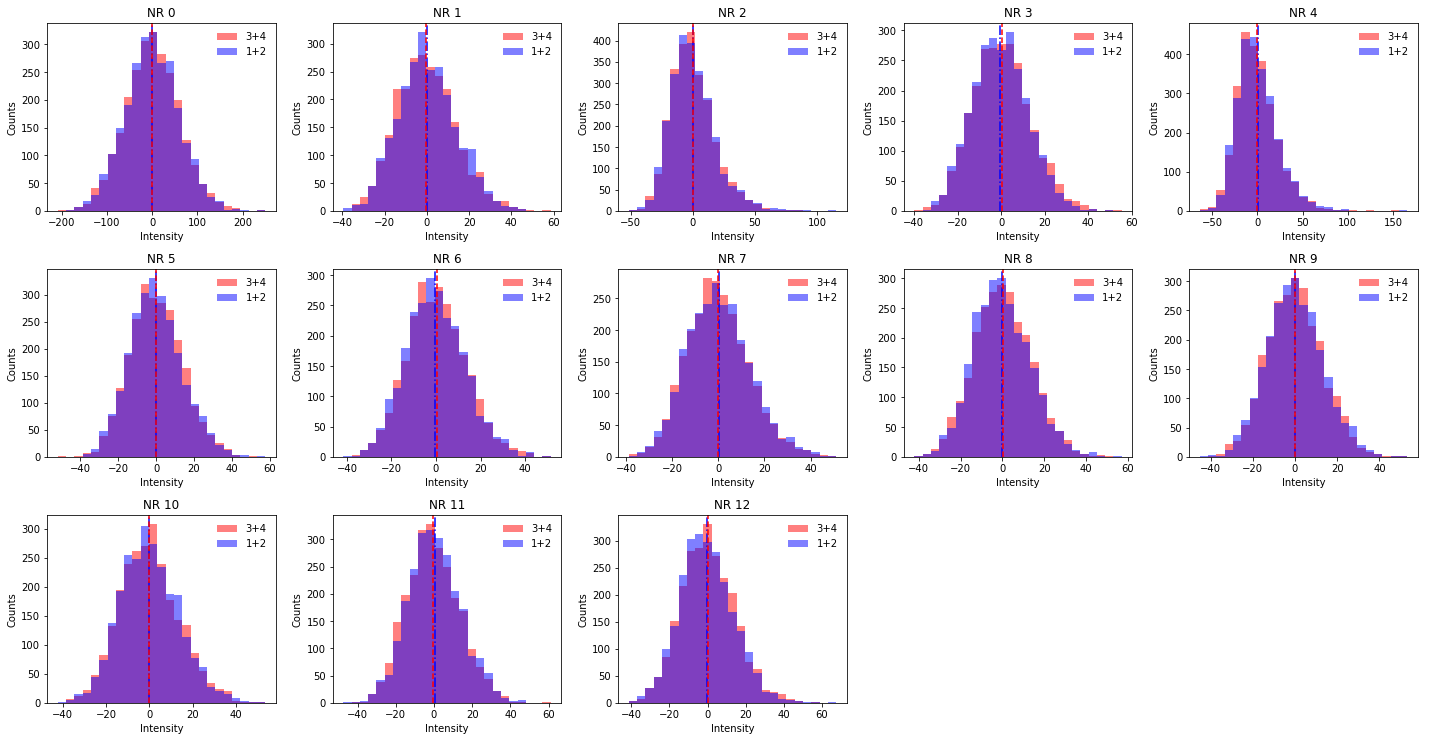

In [595]:
fig, ax = plt.subplots(len(pts)//5+1, 5, figsize=(20,len(pts)*0.8))
ax = ax.ravel()
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    c,b,p = ax[count].hist([[ttf[::4]+ttf[1::4]],[ttf[2:-1:4]+ttf[3::4]]], alpha=0.5, bins=25,
                           histtype='stepfilled',
                           color=['b','r'], 
                           label=['1+2','3+4'])
    ax[count].axvline(x=np.mean(ttf[::4]+ttf[1::4]), color='b', ls='-.')
    ax[count].axvline(x=np.mean(ttf[2:-1:4]+ttf[3::4]), color='r', ls='--')
    ax[count].set_title('NR %d' % count)
    ax[count].set_ylabel('Counts')
    ax[count].set_xlabel('Intensity')
    ax[count].legend(frameon=False)
for a in ax[count+1:]:
    a.patch.set_visible(False)
    a.axis('off')
fig.tight_layout()
plt.close(fig)
display(fig)

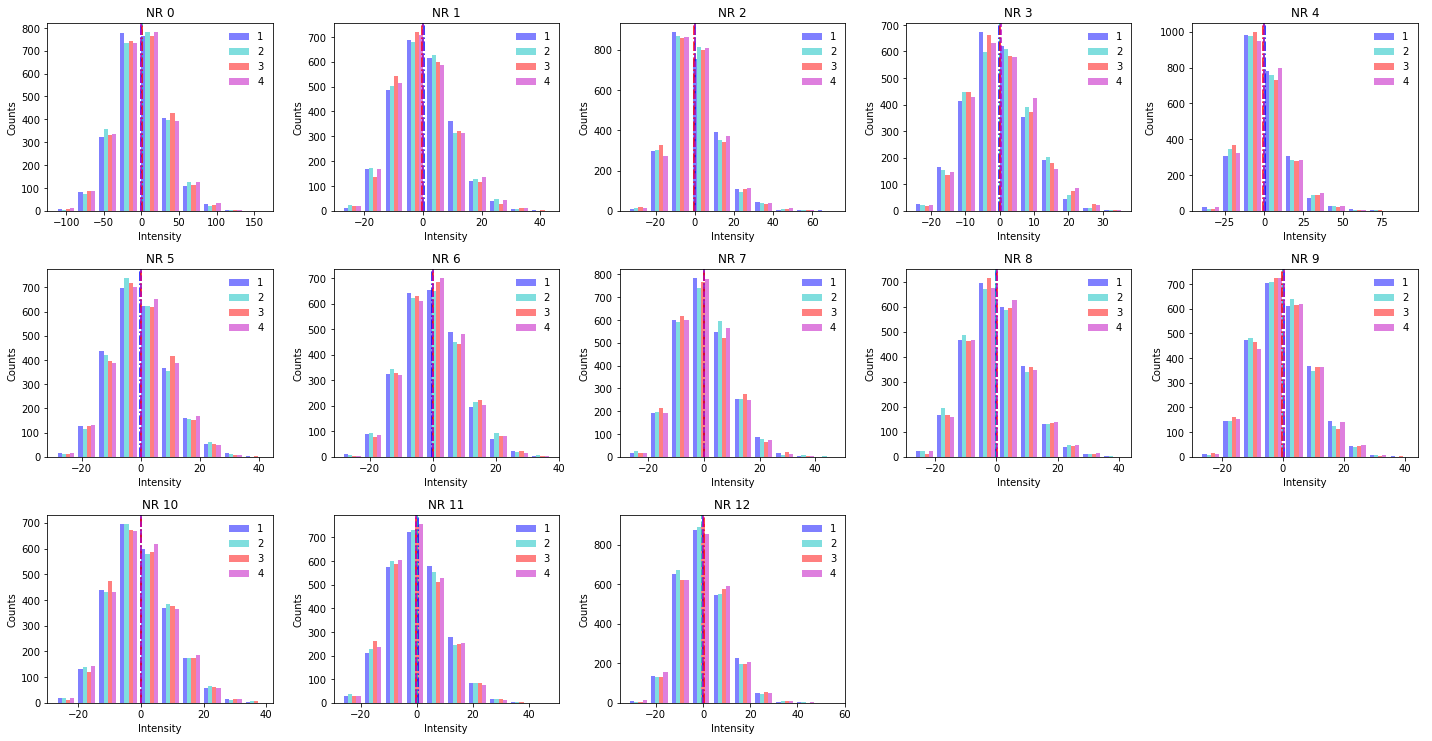

In [596]:
fig, ax = plt.subplots(len(pts)//5+1, 5, figsize=(20,len(pts)*0.8))
ax = ax.ravel()
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    c,b,p = ax[count].hist([ttf[::4],ttf[1::4],ttf[2::4],ttf[3::4]], alpha=0.5, histtype='bar',
                           color=['b','c','r','m'], 
                           label=['1','2','3','4'])
    ax[count].axvline(x=np.mean(ttf[::4]), color='b', ls='-.')
    ax[count].axvline(x=np.mean(ttf[1::4]), color='c', ls='--')
    ax[count].axvline(x=np.mean(ttf[2::4]), color='r', ls='-.')
    ax[count].axvline(x=np.mean(ttf[3::4]), color='m', ls='--')
    
    ax[count].set_title('NR %d' % count)
    ax[count].set_ylabel('Counts')
    ax[count].set_xlabel('Intensity')
    ax[count].legend(frameon=False)
for a in ax[count+1:]:
    a.patch.set_visible(False)
    a.axis('off')
fig.tight_layout()
plt.close(fig)
display(fig)

## Plot mean intensity and standard deviation of Von and Voff

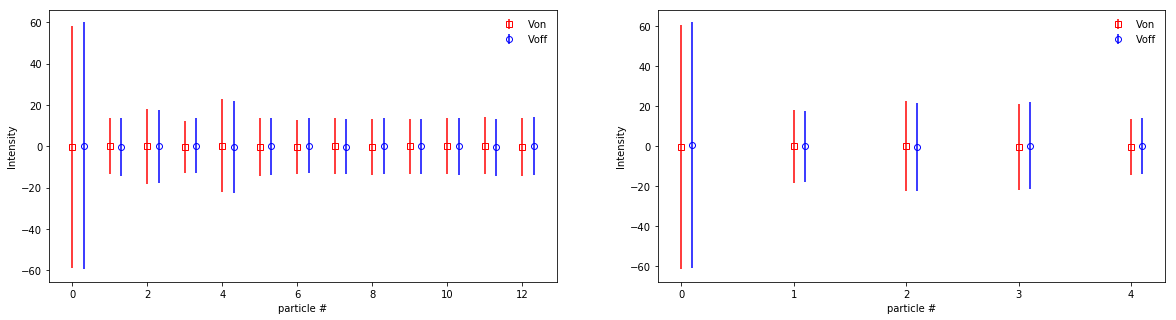

In [521]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    Von = ttf[::4]+ttf[1::4]
    Voff = ttf[2:-1:4]+ttf[3::4]
    ax[0].errorbar(x=count,     y=Von.mean(),  yerr=np.std(Von, ddof=1), c='r', fmt='s', fillstyle='none', label='Von')
    ax[0].errorbar(x=count+0.3, y=Voff.mean(), yerr=np.std(Voff, ddof=1), c='b', fmt='o', fillstyle='none', label='Voff')
    if count == 0:
        ax[0].legend(frameon=False)
for count in range(len(pts_mask)):
    tt = np.array(TT[str(count)+'mtt'])
    bg = np.array(TT[str(count)+'mbg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    Von = ttf[::4]+ttf[1::4]
    Voff = ttf[2:-1:4]+ttf[3::4]
    ax[1].errorbar(x=count,     y=Von.mean(),  yerr=np.std(Von, ddof=1), c='r', fmt='s', fillstyle='none', label='Von')
    ax[1].errorbar(x=count+0.1, y=Voff.mean(), yerr=np.std(Voff, ddof=1), c='b', fmt='o', fillstyle='none', label='Voff')
    if count == 0:
        ax[1].legend(frameon=False)
for i in range(2):
    ax[i].set_xlabel('particle #')
    ax[i].set_ylabel('Intensity')

## Plot difference between Von and Voff mean intensity
#### in-phase and out-of-phase

/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


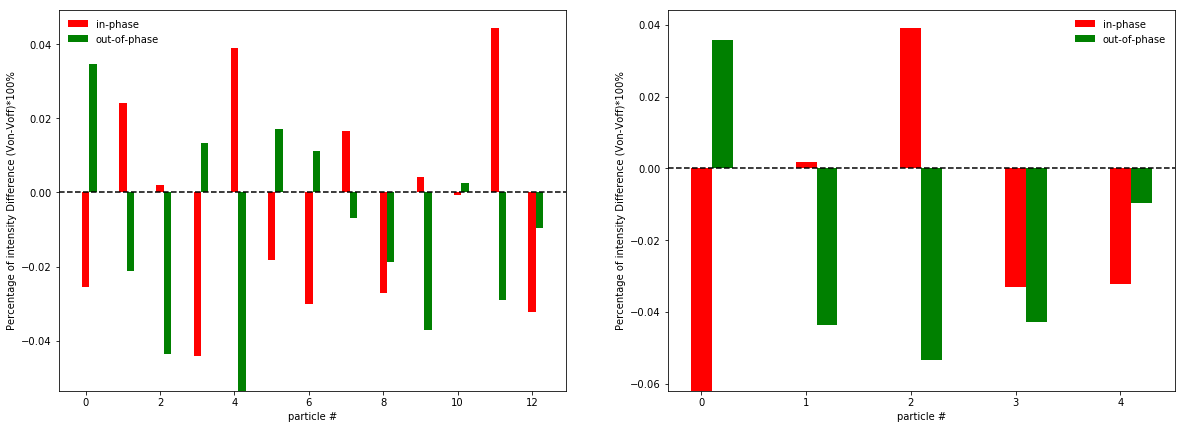

In [549]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    
    # no shift
    Von = ttf[::4]+ttf[1::4]
    Voff = ttf[2:-1:4]+ttf[3::4]
    d = Von.mean()-Voff.mean()
    yerr = np.std(d, ddof=1)
    ax[0].bar(count, d/tt.mean()*100, width=0.2, color='r', label='in-phase')
    
    # shift 1 frame
    Von = ttf[1::4]+ttf[2::4]
    Voff = ttf[3::4]+ttf[0:-4:4]
    d = Von.mean()-Voff.mean()
    yerr = np.sqrt(np.std(Von, ddof=1)**2+np.std(Voff, ddof=1)**2)
    ax[0].bar(count+0.2, d/tt.mean()*100, width=0.2, color='g', label='out-of-phase')
    if count == 0:
        ax[0].legend(frameon=False)

for count in range(len(pts_mask)):
    tt = np.array(TT[str(count)+'mtt'])
    bg = np.array(TT[str(count)+'mbg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    
    # no shift
    Von = ttf[::4]+ttf[1::4]
    Voff = ttf[2:-1:4]+ttf[3::4]
    d = Von.mean()-Voff.mean()
    yerr = np.std(d, ddof=1)
    ax[1].bar(count, d/tt.mean()*100, width=0.2, color='r', label='in-phase')
    
    # shift 1 frame
    Von = ttf[1::4]+ttf[2::4]
    Voff = ttf[3::4]+ttf[0:-4:4]
    d = Von.mean()-Voff.mean()
    yerr = np.sqrt(np.std(Von, ddof=1)**2+np.std(Voff, ddof=1)**2)
    ax[1].bar(count+0.2, d/tt.mean()*100, width=0.2, color='g', label='out-of-phase')
    if count == 0:
        ax[1].legend(frameon=False)
        
        
for i in range(2):
    ax[i].set_xlabel('particle #')
    ax[i].set_ylabel('Percentage of intensity Difference (Von-Voff)*100%')
    ax[i].axhline(y=0, ls='--', color='k')

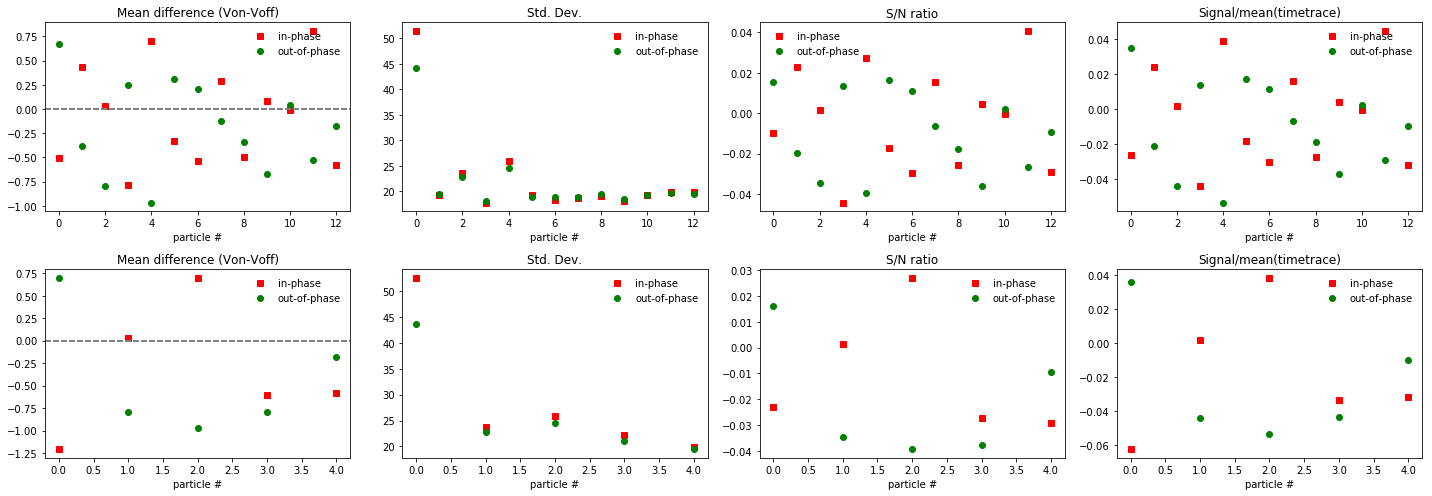

In [547]:
fig, ax = plt.subplots(2,4, figsize=(20,7))

# NR selected from point detection function
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    
    # no shift
    Von = ttf[::4]+ttf[1::4]
    Voff = ttf[2:-1:4]+ttf[3::4]
    d = Von[:-1]-Voff
    yerr = np.std(d, ddof=1)
    ax[0,0].plot(count, d.mean(), 'rs', label='in-phase')
    ax[0,1].plot(count, np.std(d, ddof=1), 'rs', label='in-phase')
    ax[0,2].plot(count, d.mean()/np.std(d, ddof=1), 'rs', label='in-phase')
    ax[0,3].plot(count, d.mean()/tt.mean()*100, 'rs', label='in-phase')
    
    # shift 1 frame
    Von = ttf[1::4]+ttf[2::4]
    Voff = ttf[3::4]+ttf[0:-4:4]
    d = Von[:-1]-Voff
    yerr = np.std(d, ddof=1)
    ax[0,0].plot(count, d.mean(), 'go', label='out-of-phase')
    ax[0,1].plot(count, np.std(d, ddof=1), 'go', label='out-of-phase')
    ax[0,2].plot(count, d.mean()/np.std(d, ddof=1), 'go', label='out-of-phase')
    ax[0,3].plot(count, d.mean()/tt.mean()*100, 'go', label='out-of-phase')
    ax[0,0].set_title('Mean difference (Von-Voff)')
    ax[0,1].set_title('Std. Dev.')
    ax[0,2].set_title('S/N ratio')
    ax[0,3].set_title('Signal/mean(timetrace)')
    ax[0,0].axhline(y=0, ls='--', color='gray')
    if count == 0:
        for i in range(4):
            ax[0,i].legend(frameon=False)

# NR selected from mask 
for count in range(len(pts_mask)):
    tt = np.array(TT[str(count)+'mtt'])
    bg = np.array(TT[str(count)+'mbg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    
    # no shift
    Von = ttf[::4]+ttf[1::4]
    Voff = ttf[2:-1:4]+ttf[3::4]
    d = Von[:-1]-Voff
    yerr = np.std(d, ddof=1)
    ax[1,0].plot(count, d.mean(), 'rs', label='in-phase')
    ax[1,1].plot(count, np.std(d, ddof=1), 'rs', label='in-phase')
    ax[1,2].plot(count, d.mean()/np.std(d, ddof=1), 'rs', label='in-phase')
    ax[1,3].plot(count, d.mean()/tt.mean()*100, 'rs', label='in-phase')
    
    # shift 1 frame
    Von = ttf[1::4]+ttf[2::4]
    Voff = ttf[3::4]+ttf[0:-4:4]
    d = Von[:-1]-Voff
    yerr = np.std(d, ddof=1)
    ax[1,0].plot(count, d.mean(), 'go', label='out-of-phase')
    ax[1,1].plot(count, np.std(d, ddof=1), 'go', label='out-of-phase')
    ax[1,2].plot(count, d.mean()/np.std(d, ddof=1), 'go', label='out-of-phase')
    ax[1,3].plot(count, d.mean()/tt.mean()*100, 'go', label='out-of-phase')
    ax[1,0].set_title('Mean difference (Von-Voff)')
    ax[1,1].set_title('Std. Dev.')
    ax[1,2].set_title('S/N ratio')
    ax[1,3].set_title('Signal/mean(timetrace)')
    ax[1,0].axhline(y=0, ls='--', color='gray')
    
    if count == 0:
        for i in range(4):
            ax[1,i].legend(frameon=False)

           
            
for i in range(2):
    for j in range(4):
        ax[i,j].set_xlabel('particle #')
fig.tight_layout()

## Signal v.s. time

In [587]:
window_size = 20

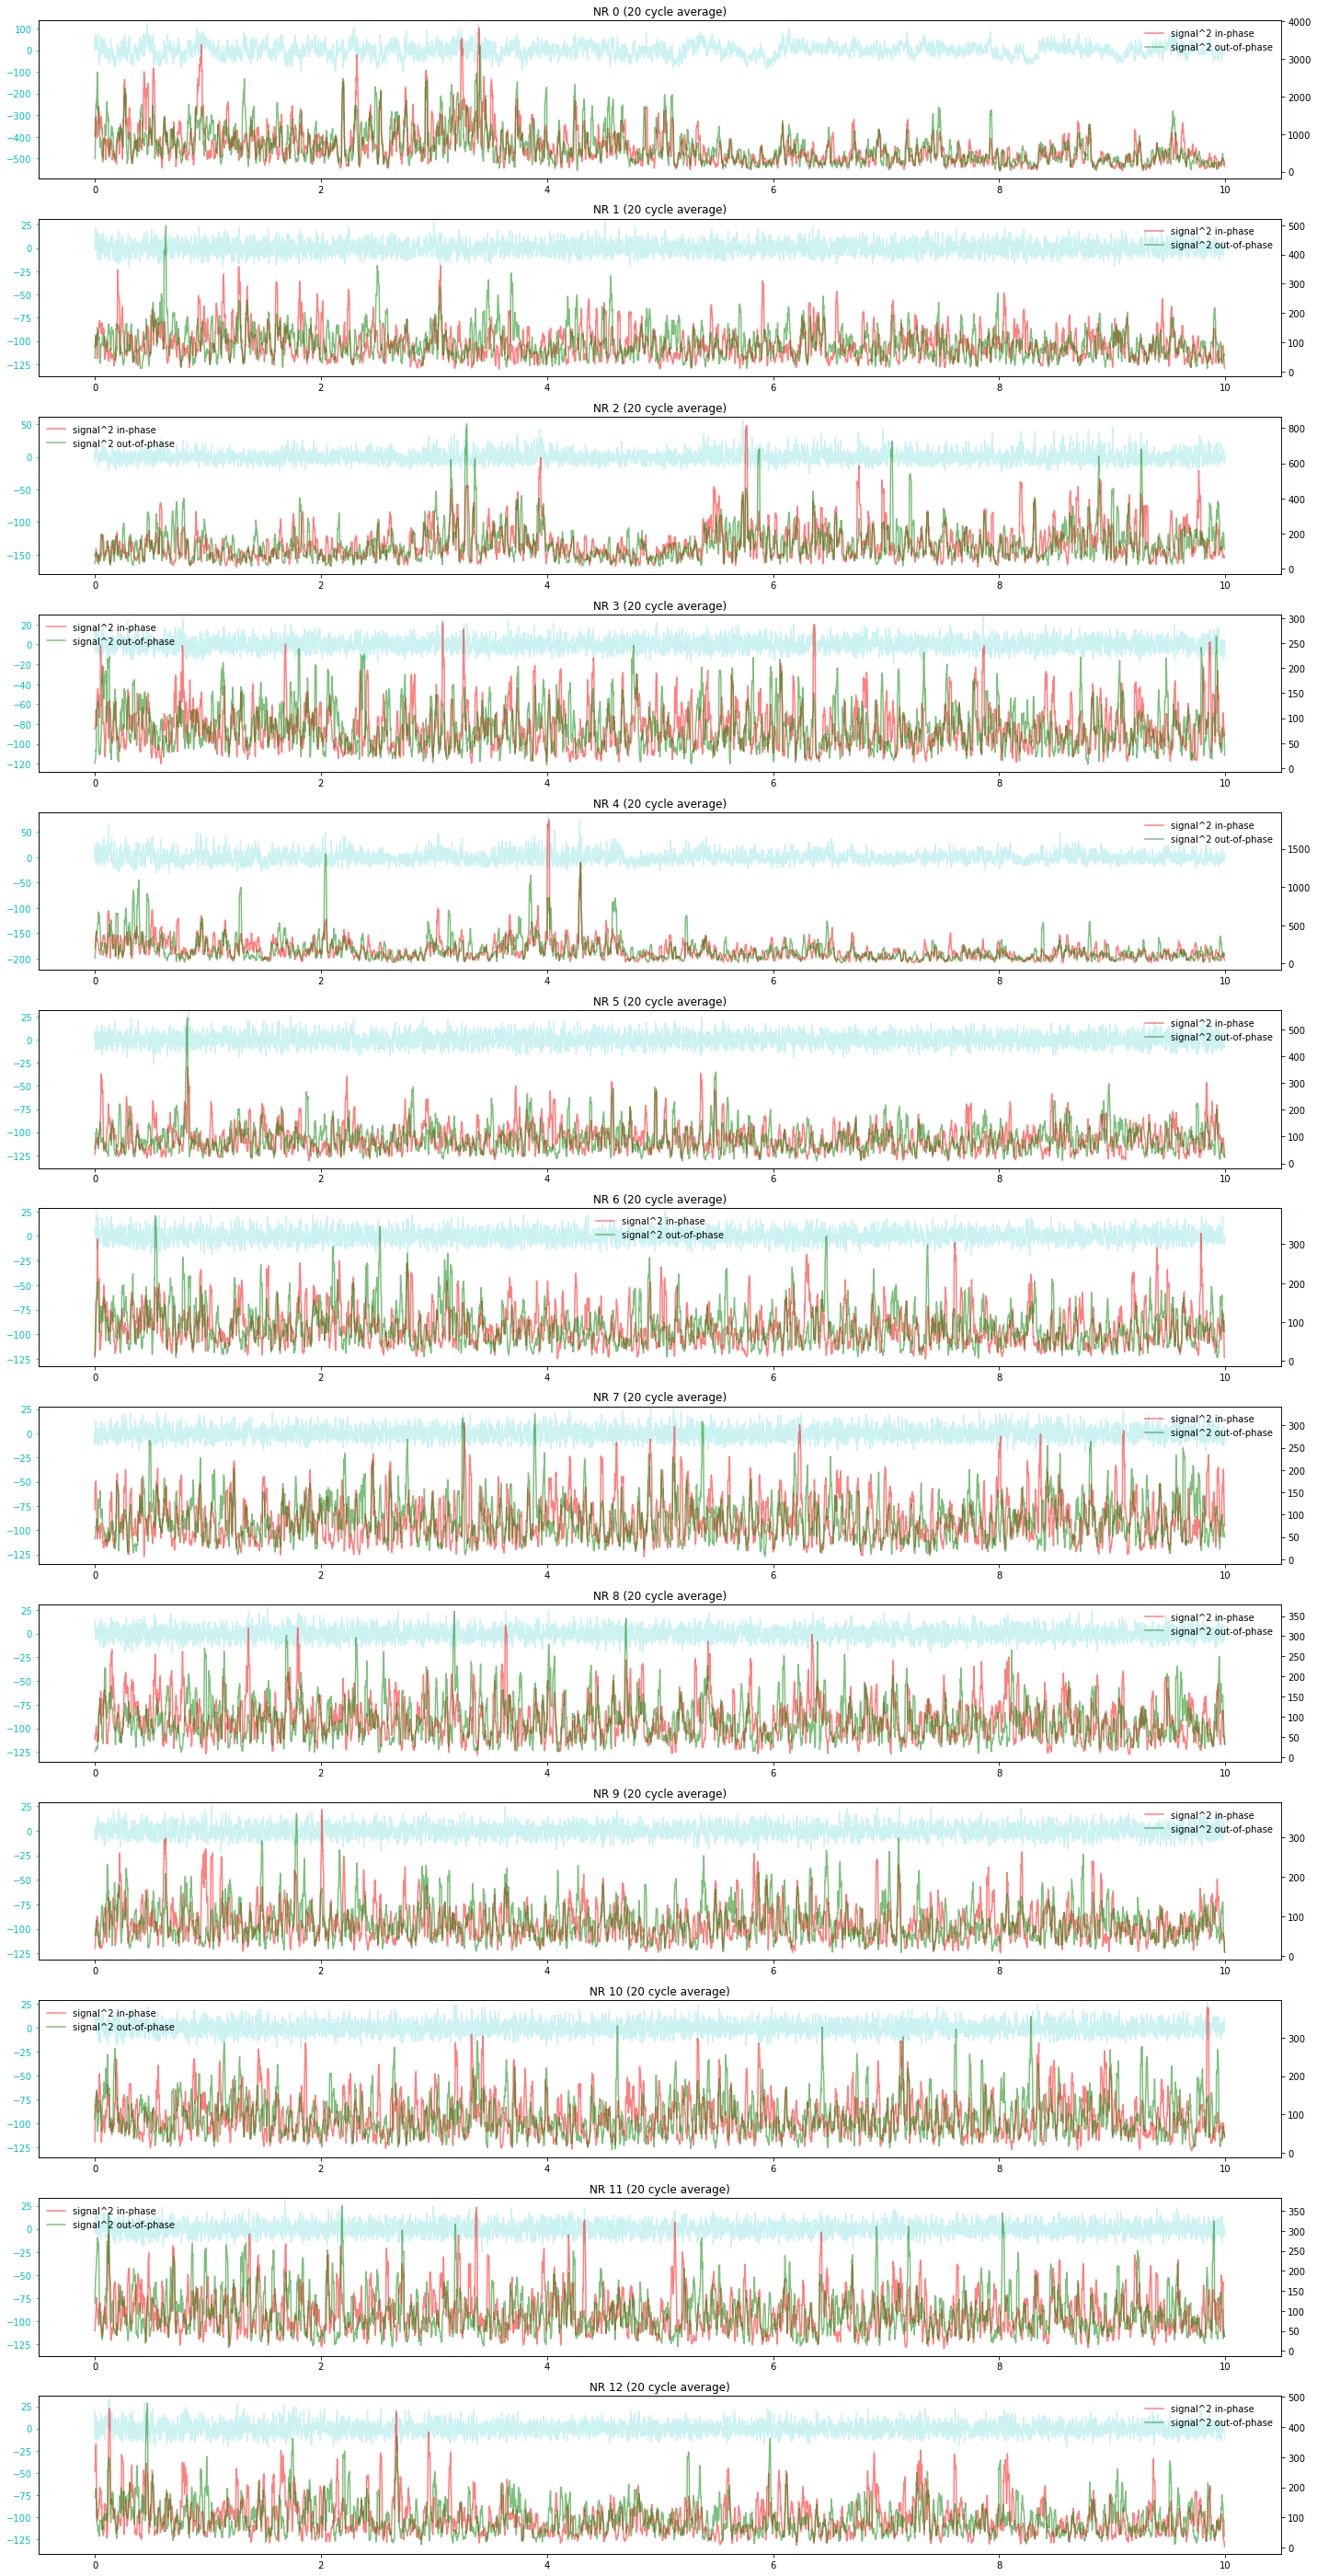

In [590]:
fig, ax = plt.subplots(len(pts), figsize=(20,len(pts)*3))

# NR selected from point detection function
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    ttf2 = (ttf[:-1:2]+ttf[1::2])/2
    dp = np.diff(ttf2)
    dn = np.diff(np.roll(ttf2,1))
    d = np.insert(dp, np.arange(len(dn)), dn)
    ax[count].plot(T[:-1:2], ttf2, 'c', label='time trace', alpha=0.2)
    ax[count].set_title('NR %d (%d cycle average)' % (count, window_size))
    ax[count].set_ylim(ttf2.mean()-np.std(ttf2)*20)
    axt = ax[count].twinx()
    axt.plot(T[:-3:], movingaverage(d**2,window_size), 'r',label='signal^2 in-phase', alpha=0.5)
    ax[count].spines['right'].set_color('c')
    ax[count].yaxis.label.set_color('c')
    ax[count].tick_params(axis='y', colors='c')
    
    
    ttf2 = (ttf[1:-1:2]+ttf[2::2])/2
    dp = np.diff(ttf2)
    dn = np.diff(np.roll(ttf2,1))
    d = np.insert(dp, np.arange(len(dn)), dn)
    axt.plot(T[:-3:], movingaverage(d**2,window_size), 'g',label='signal^2 out-of-phase', alpha=0.5)
    axt.legend(frameon=False)
fig.tight_layout()

In [587]:
window_size = 20

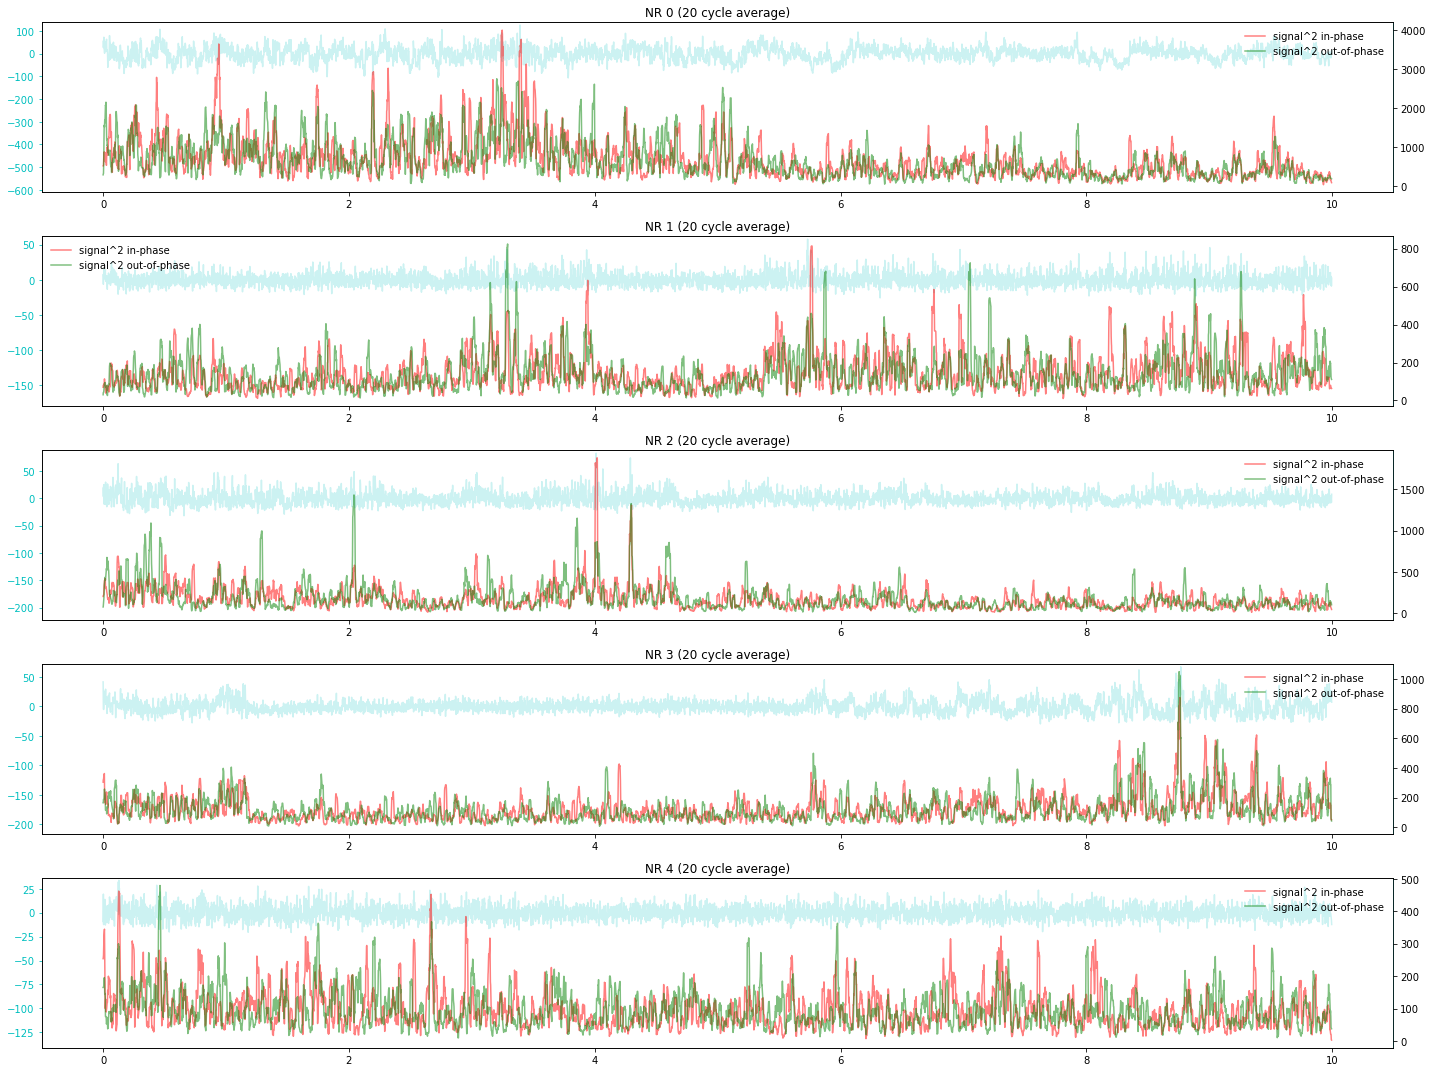

In [591]:
fig, ax = plt.subplots(len(pts_mask), figsize=(20,len(pts_mask)*3))

# NR selected from mask
for count in range(len(pts_mask)):
    tt = np.array(TT[str(count)+'mtt'])
    bg = np.array(TT[str(count)+'mbg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    ttf2 = (ttf[:-1:2]+ttf[1::2])/2
    dp = np.diff(ttf2)
    dn = np.diff(np.roll(ttf2,1))
    d = np.insert(dp, np.arange(len(dn)), dn)
    ax[count].plot(T[:-1:2], ttf2, 'c', label='time trace', alpha=0.2)
    ax[count].set_title('NR %d (%d cycle average)' % (count, window_size))
    ax[count].set_ylim(ttf2.mean()-np.std(ttf2)*20)
    axt = ax[count].twinx()
    axt.plot(T[:-3:], movingaverage(d**2,window_size), 'r',label='signal^2 in-phase', alpha=0.5)
    ax[count].spines['right'].set_color('c')
    ax[count].yaxis.label.set_color('c')
    ax[count].tick_params(axis='y', colors='c')
    
    ttf2 = (ttf[1:-1:2]+ttf[2::2])/2
    dp = np.diff(ttf2)
    dn = np.diff(np.roll(ttf2,1))
    d = np.insert(dp, np.arange(len(dn)), dn)
    axt.plot(T[:-3:], movingaverage(d**2,window_size), 'g',label='signal^2 out-of-phase', alpha=0.5)
    axt.legend(frameon=False)
fig.tight_layout()

## Auto-correlation analysis

In [680]:
def get_acr_tt(tt):
    tt = tt - np.mean(tt[:])
    acr = np.correlate(tt, tt, mode='full')/(tt*tt).sum()
    acr = acr[len(tt)-1:]
    return acr

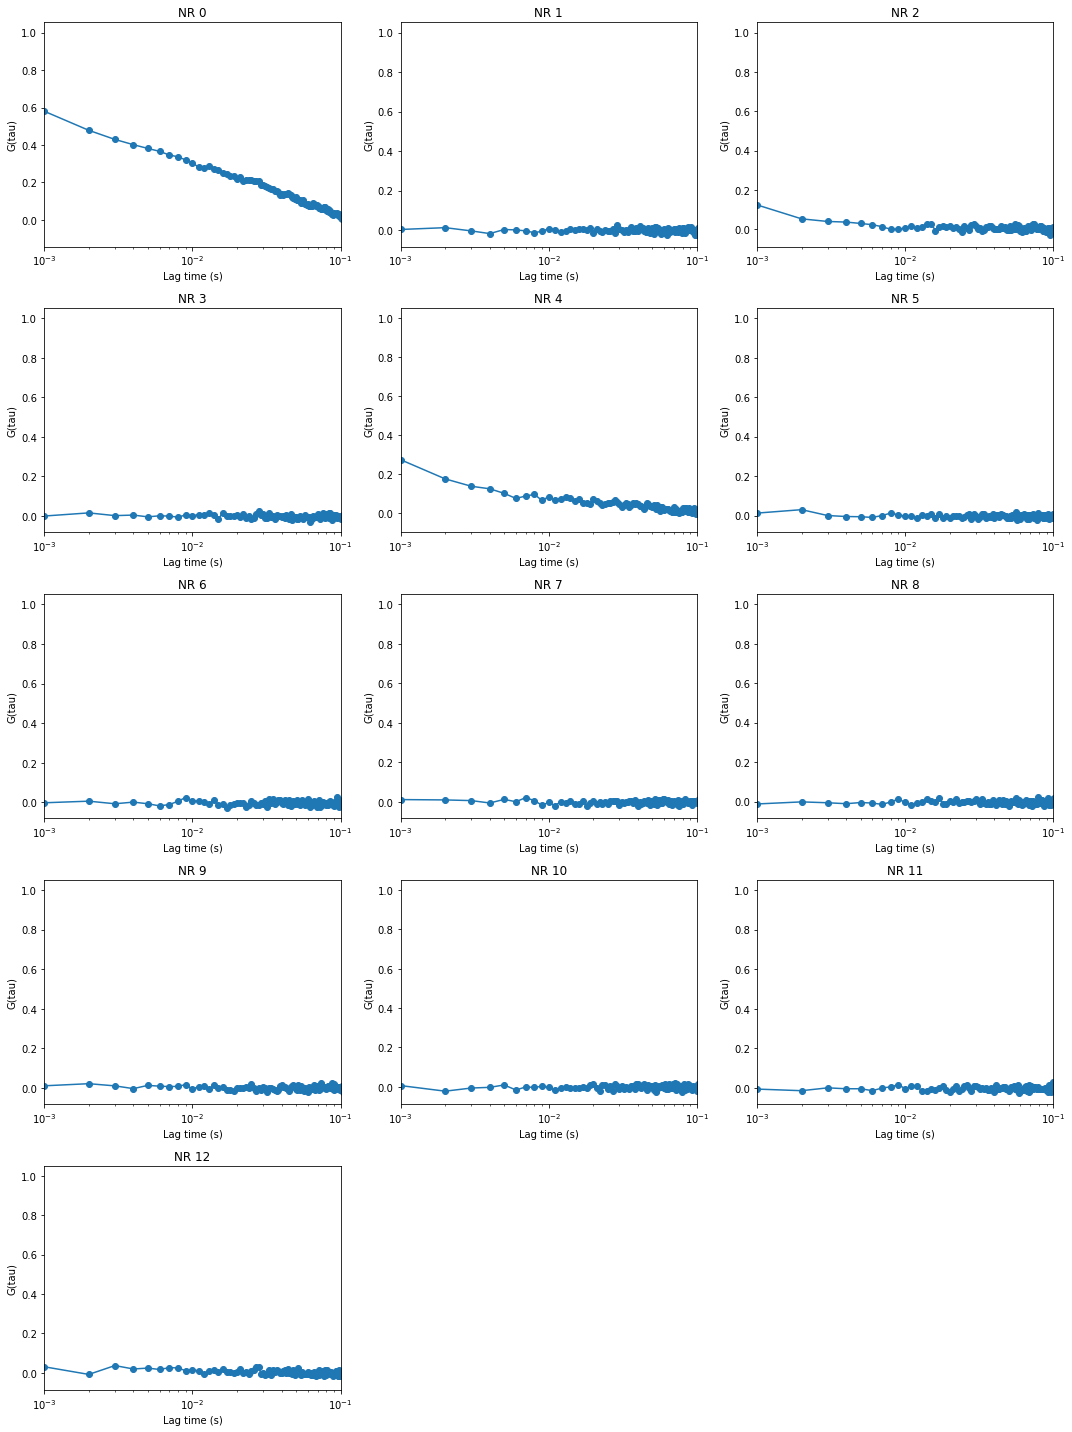

In [711]:
fig, ax = plt.subplots(len(pts)//3+np.any((len(pts)%3)), 3, figsize=(15,(len(pts)//3+np.any((len(pts)%3)))*4))
ax = ax.ravel()
# NR selected from point detection function
for count in range(len(pts)):
    tt = np.array(TT[str(count)+'tt'])
    bg = np.array(TT[str(count)+'bg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    acr = get_acr_tt(ttf)
    ax[count].semilogx(np.arange(0,len(acr)/framerate, 1/framerate), acr, '-o')
    ax[count].set_xlabel('Lag time (s)')
    ax[count].set_ylabel('G(tau)')
    #ax[count].set_xscale('symlog')
    ax[count].set_xlim(0,0.1)
    #ax[count].set_ylim(0,0.05)
    ax[count].set_title('NR %d' % count)
for a in ax[count+1:]:
    a.patch.set_visible(False)
    a.axis('off')
fig.tight_layout()
plt.close(fig)
display(fig)
fig.tight_layout()

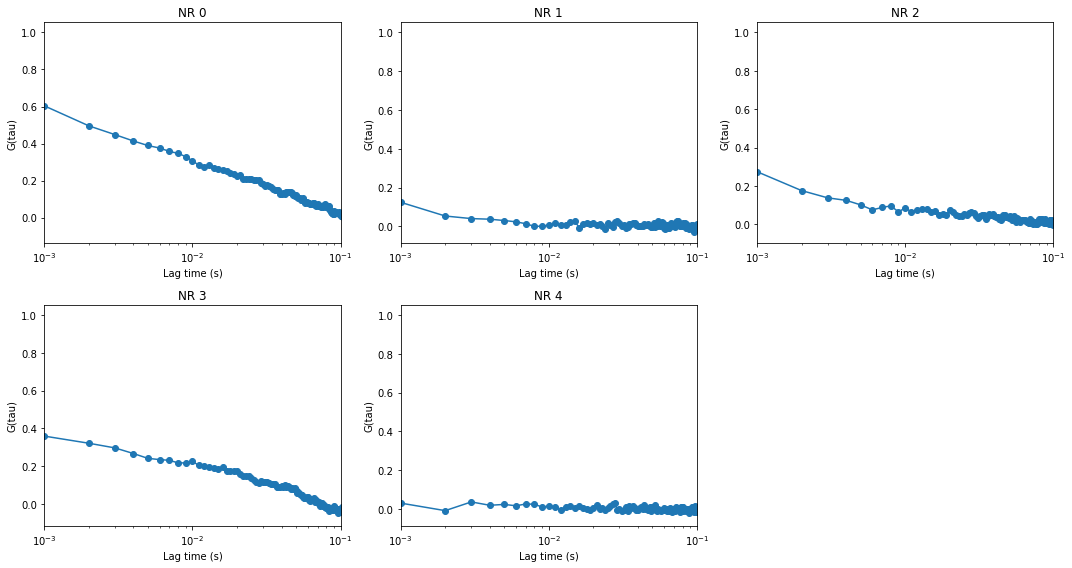

In [712]:
fig, ax = plt.subplots(len(pts_mask)//3+np.any((len(pts_mask)%3)), 3, figsize=(15,(len(pts_mask)//3+np.any((len(pts_mask)%3)))*4))
ax = ax.ravel()
# NR selected from mask
for count in range(len(pts_mask)):
    tt = np.array(TT[str(count)+'mtt'])
    bg = np.array(TT[str(count)+'mbg'])
    trend = ndi.filters.gaussian_filter1d(tt-bg, detrend_sigma)
    ttf = tt-bg-trend
    acr = get_acr_tt(ttf)
    ax[count].semilogx(np.arange(0,len(acr)/framerate, 1/framerate), acr, '-o')
    ax[count].set_xlabel('Lag time (s)')
    ax[count].set_ylabel('G(tau)')
    #ax[count].set_xscale('symlog')
    ax[count].set_xlim(0,0.1)
    #ax[count].set_ylim(0,0.05)
    ax[count].set_title('NR %d' % count)
for a in ax[count+1:]:
    a.patch.set_visible(False)
    a.axis('off')
fig.tight_layout()
plt.close(fig)
display(fig)
fig.tight_layout()